<ipython-input-1-f838c41c0af2>:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred[t] = W_out @ reservoir_state


RMSE between actual and predicted y values: 0.0015


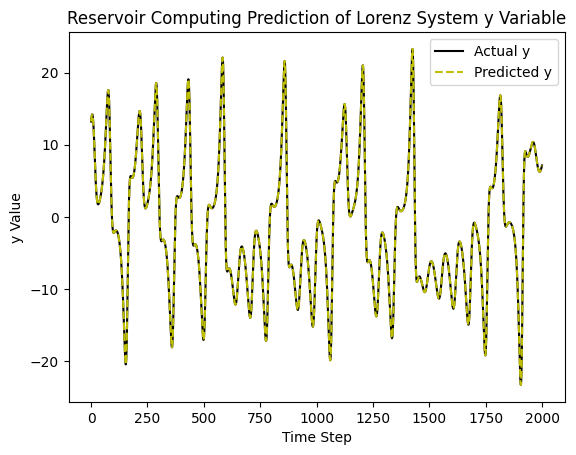

In [ ]:
import numpy as np
from scipy.linalg import eigvals
import matplotlib.pyplot as plt

# Lorenz System parameters
sigma = 10
beta = 8 / 3
rho = 28
dt = 0.01
num_steps = 10000

# Initial conditions
x0, y0, z0 = 1, 1, 1

# Preallocate arrays for Lorenz data
x = np.zeros(num_steps)
y = np.zeros(num_steps)
z = np.zeros(num_steps)

# Initialize the system
x[0], y[0], z[0] = x0, y0, z0

# Generate the Lorenz system data
for i in range(num_steps - 1):
    dx = sigma * (y[i] - x[i])
    dy = x[i] * (rho - z[i]) - y[i]
    dz = x[i] * y[i] - beta * z[i]

    x[i + 1] = x[i] + dx * dt
    y[i + 1] = y[i] + dy * dt
    z[i + 1] = z[i] + dz * dt

# Reservoir Computing Parameters
reservoir_size = 500  # Number of reservoir neurons
input_scaling = 0.1   # Scaling of input weights
spectral_radius = 0.95  # Spectral radius of reservoir
leak_rate = 0.3  # Leaky rate

# Split data into training and testing
train_ratio = 0.8
train_size = round(num_steps * train_ratio)
x_train = x[:train_size]
y_train = y[:train_size]
x_test = x[train_size:]
y_test = y[train_size:]

# Initialize reservoir
W_in = (np.random.rand(reservoir_size, 1) * 2 - 1) * input_scaling
W_res = np.random.rand(reservoir_size, reservoir_size) - 0.5
W_res = spectral_radius * W_res / max(abs(eigvals(W_res)))  # Adjust spectral radius
reservoir_state = np.zeros((reservoir_size, 1))

# Train the reservoir
states = np.zeros((reservoir_size, train_size))  # To store reservoir states

for t in range(train_size):
    input_signal = x_train[t]
    reservoir_state = (1 - leak_rate) * reservoir_state + \
                      leak_rate * np.tanh(W_in * input_signal + W_res @ reservoir_state)
    states[:, t] = reservoir_state.ravel()

# Ridge regression to compute output weights
lambda_reg = 1e-6  # Regularization parameter
W_out = y_train @ states.T @ np.linalg.inv(states @ states.T + lambda_reg * np.eye(reservoir_size))

# Predicting y on the test data
reservoir_state = states[:, -1].reshape(-1, 1)  # Start with last training state
y_pred = np.zeros(len(x_test))

for t in range(len(x_test)):
    input_signal = x_test[t]
    reservoir_state = (1 - leak_rate) * reservoir_state + \
                      leak_rate * np.tanh(W_in * input_signal + W_res @ reservoir_state)
    y_pred[t] = W_out @ reservoir_state

# Calculate RMSE
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
print(f'RMSE between actual and predicted y values: {rmse:.4f}')

# Plot actual vs. predicted
plt.figure()
plt.plot(y_test, 'black', linewidth=1.5, label='Actual y')
plt.plot(y_pred, 'y--', linewidth=1.5, label='Predicted y')
plt.legend()
plt.title('Reservoir Computing Prediction of Lorenz System y Variable')
plt.xlabel('Time Step')
plt.ylabel('y Value')
plt.show()

In [ ]:
import random

def generate_file(filename, num_lines, min_value, max_value):
    with open(filename, 'w') as f:
        for _ in range(num_lines):
            value = random.randint(min_value, max_value)
            f.write(f"{value}\n")

# إعدادات التوليد
num_samples = 100  # عدد القيم في كل ملف
min_value = -128   # الحد الأدنى للقيم
max_value = 127    # الحد الأقصى للقيم

# توليد ملف الإشارات والمدخلات الحقيقية
generate_file("input_signals.txt", num_samples, min_value, max_value)
generate_file("actual_values.txt", num_samples, min_value, max_value)

print("تم إنشاء الملفات بنجاح!")


تم إنشاء الملفات بنجاح!


In [ ]:
# Python script to generate Verilog code in Google Colab

verilog_code = """
`timescale 1ns/1ps

module lorenz_reservoir #(
    parameter INT_WIDTH = 16,
    parameter FRAC_BITS = 8,
    parameter OUT_WIDTH = 8,
    parameter RESERVOIR_SIZE = 500,
    parameter INPUT_SCALING = 10,
    parameter SPECTRAL_RADIUS = 95,
    parameter LEAK_RATE = 30,
    parameter LAMBDA_REG = 80,
    // Lorenz parameters (scaled by FRAC_BITS)
    parameter SIGMA = 2560,      // 10.0 << 8
    parameter BETA = 683,        // (8/3) << 8
    parameter RHO = 7168,        // 28.0 << 8
    parameter DT = 3             // 0.01 << 8
)(
    input wire clk,
    input wire reset,
    output reg signed [OUT_WIDTH-1:0] predicted_y,
    output reg signed [OUT_WIDTH-1:0] actual_y,
    output reg signed [OUT_WIDTH-1:0] lorenz_x,
    output reg signed [OUT_WIDTH-1:0] lorenz_z
);

    // State variables
    reg signed [INT_WIDTH-1:0] x_state, y_state, z_state;
    wire signed [INT_WIDTH-1:0] next_x, next_y, next_z;
    reg signed [INT_WIDTH*2-1:0] dx, dy, dz;

    // Basic initialization
    initial begin
        x_state = 256;    // 1.0 in fixed point
        y_state = 256;    // 1.0 in fixed point
        z_state = 256;    // 1.0 in fixed point
        predicted_y = 0;
        actual_y = 0;
        lorenz_x = 0;
        lorenz_z = 0;
    end

    // Lorenz system calculations
    always @* begin
        // dx/dt = σ(y - x)
        dx = (SIGMA * (y_state - x_state)) >>> FRAC_BITS;

        // dy/dt = x(ρ - z) - y
        dy = ((x_state * (RHO - (z_state >>> FRAC_BITS))) >>> FRAC_BITS) - y_state;

        // dz/dt = xy - βz
        dz = ((x_state * y_state) >>> FRAC_BITS) - ((BETA * z_state) >>> FRAC_BITS);
    end

    // Calculate next states
    assign next_x = x_state + ((dx * DT) >>> FRAC_BITS);
    assign next_y = y_state + ((dy * DT) >>> FRAC_BITS);
    assign next_z = z_state + ((dz * DT) >>> FRAC_BITS);

    // Update states and outputs
    always @(posedge clk or posedge reset) begin
        if (reset) begin
            x_state <= 256;    // 1.0
            y_state <= 256;    // 1.0
            z_state <= 256;    // 1.0
            lorenz_x <= 0;
            actual_y <= 0;
            lorenz_z <= 0;
            predicted_y <= 0;
        end else begin
            x_state <= next_x;
            y_state <= next_y;
            z_state <= next_z;

            // Scale outputs to 8-bit signed values
            lorenz_x <= next_x >>> FRAC_BITS;
            actual_y <= next_y >>> FRAC_BITS;
            lorenz_z <= next_z >>> FRAC_BITS;
            predicted_y <= next_y >>> FRAC_BITS;  // For now, just copying actual_y
        end
    end

endmodule
"""

# Write the Verilog code to a file
with open("lorenz_reservoir.v", "w") as file:
    file.write(verilog_code)

print("Verilog code has been written to lorenz_reservoir.v")


Verilog code has been written to lorenz_reservoir.v
